In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
from nilearn import signal
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiMapsMasker
from nilearn.plotting import plot_roi, plot_stat_map,plot_epi
from nilearn.image import new_img_like
import nilearn as nl 
import nibabel as nib
from nilearn import datasets
from sklearn.decomposition import PCA
import bids
import os
import glob
import ray
import psutil


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Homemade functions

In [2]:
ray.shutdown()

num_cpus = psutil.cpu_count(logical=False)

ray.init(num_cpus=num_cpus)

@ray.remote
def fit_mask_get_PC1(current_mask, sub_data):
    try:
        fit_2_mask = current_mask.fit_transform(sub_data)
        PCA_instance = PCA(n_components=1)
        PCA_instance.fit(fit_2_mask)
        PC1_score = PCA_instance.explained_variance_ratio_[0]
    except ValueError:
        PC1_score = 0
    return PC1_score


2023-09-16 15:48:38,391	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [331]:
ray.shutdown()

num_cpus = psutil.cpu_count(logical=False)

ray.init(num_cpus=num_cpus)

@ray.remote
def apply_GM_Mask_2_RS(rs_data, gm_data, current_participant, condition, save_folder): 
    
    # Load gm mask raw data
    gm_data_file = nib.load(gm_data) 

    # Create first mask using (mask_type="gm")
    gm_mask1 = nl.masking.compute_brain_mask(gm_data_file, mask_type="gm", opening=False) 

    # Create second mask as a "NiftiMasker" obj.
    gm_mask2 = NiftiMasker(gm_mask1).fit() 

    # Apply gm_mask2 to rs_data.  
    rs_data_masked = gm_mask2.fit_transform(rs_data)

    # Convert rs_data_masked to volumetric shape.
    rs_data_masked_vol = gm_mask2.inverse_transform(rs_data_masked)

    # Save "rs_data_masked_vol" as ".nii" file.
    new_file_name = save_folder + condition + current_participant + "_gm_masked_vol.nii.gz"
    rs_data_masked_vol.to_filename(new_file_name)


2023-09-17 16:32:43,233	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [1]:
ray.shutdown()

NameError: name 'ray' is not defined

In [316]:
def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            return file

def get_anat_files(path):
    
    str_list = glob.glob(path + '*c1*')
    
    if os.path.isfile(str_list[0]):
       
        file = str_list[0]

        #print(file)

        return file
    else: 
        print("Not yet.")
        print(str(glob.glob(path + 'wc1mpr*')))

## Open Directory

In [317]:
# Now open a directory/folder 
fd = os.open("/Users/luisalvarez/Documents/Research_Elective_Data", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Research_Elective_Data


In [138]:
# Store the "path's" for each '.nii' file

# Store file names
COC_paths = []
PLA_paths = []
C1_paths = []

# Set paths for each session folder
dir_path1 = os.getcwd()
dir_path1 += "/CANCOC_PP_1"

# Iterate directory
for path in os.listdir("CANCOC_PP_1"):
    
    if os.path.isdir(os.path.join(dir_path1, path)):
           
        currentsub_path = os.path.join(dir_path1, path)
            
        path_coc = path+"COC"
        path_pla = path+"PLA"
        path_anat = "anat/"
    
        # Get COC files.
        if os.path.isdir(os.path.join(currentsub_path, path_coc)): 
            current_sub_coc_file = get_files(os.path.join(currentsub_path, path_coc))
            current_sub_coc_file = os.path.join(os.path.join(os.path.join("CANCOC_PP_1/", path), path_coc), current_sub_coc_file)
            COC_paths.append(current_sub_coc_file)
        else: 
            print(os.path.join(currentsub_path, path_coc))

        # Get PLA files.
        if os.path.isdir(os.path.join(currentsub_path, path_pla)): 
            current_sub_pla_file = get_files(os.path.join(currentsub_path, path_pla))
            current_sub_pla_file = os.path.join(os.path.join(os.path.join("CANCOC_PP_1/", path), path_pla), current_sub_pla_file)
            PLA_paths.append(current_sub_pla_file)

        # Get anat -> c1 files.
        if os.path.isdir(os.path.join(currentsub_path, path_anat)): 
            current_sub_anat_file = get_anat_files(os.path.join(currentsub_path, path_anat))
            C1_paths.append(current_sub_anat_file)

    else:
        print(path + ": false")
        



.DS_Store: false


In [323]:
# Get list of participating subjects. 

p_path = str(os.getcwd() + "/CANCOC_PP_1")

paritipants_list = os.listdir(p_path)
paritipants_list.pop(0)
print("paritipants_list: " + str(paritipants_list))


paritipants_list: ['P5259', 'P5232', 'P5235', 'P5203', 'P5258', 'P52125', 'P5260', 'P5205', 'P5234', 'P5233', 'P5211', 'P5229', 'P5216', 'P5220', 'P5218', 'P5227', 'P5245', 'P5228', 'P5210', 'P5244', 'P5243', 'P5236', 'P5209', 'P5231', 'P5207', 'P5238', 'P5254', 'P5253', 'P5201', 'P5206', 'P5230', 'P5237', 'P5208', 'P5252', 'P5215', 'P5212', 'P5224', 'P5247', 'P5249', 'P5225']


# Load functional image for subject 1 (P5259)

In [6]:
tr_drop = 5
sub1_coc = image.load_img(COC_PP_1_paths[0])
sub1_pla = image.load_img(PLA_PP_1_paths[0])

#Remove the first 5 TRs
sub1_coc = sub1_coc.slicer[:,:,:,tr_drop:]
sub1_pla = sub1_pla.slicer[:,:,:,tr_drop:]

print("sub1_coc shape: %s" % str(sub1_coc.shape))
print("sub1_pla shape: %s" % str(sub1_pla.shape))


sub1_coc shape: (79, 95, 69, 131)
sub1_pla shape: (79, 95, 69, 123)


# Remove voxels associated with masks

My understanding is that given the file names "wc1mpr_5201_20100319.nii", this is what they represent. I will be using the "*c1" files to retain voxels associated with gray matter and filter out all other voxels.
<br>w is warped to MNI space
<br>c1 is tissue class 1, gray matter [by default]
<br>c2 is white matter [by default]
<br>c3 is cerebrospinal fluid, CSF  [by default]

## Check C1 gray matterr masks with first participant

C1_img_sub1 shape: (91, 109, 91)
C1_sub1_masker type:<class 'nilearn.maskers.nifti_masker.NiftiMasker'>
C1_sub1_masker shape:(91, 109, 91)


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


C1_sub1_masker_data_binarized shape: (91, 109, 91)


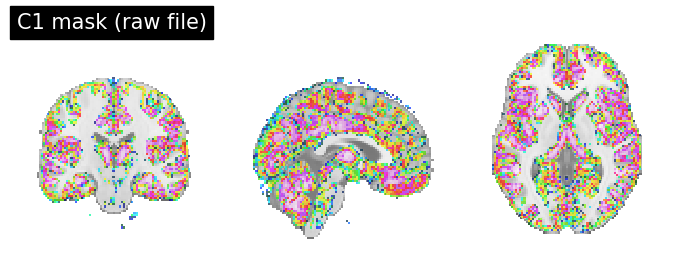

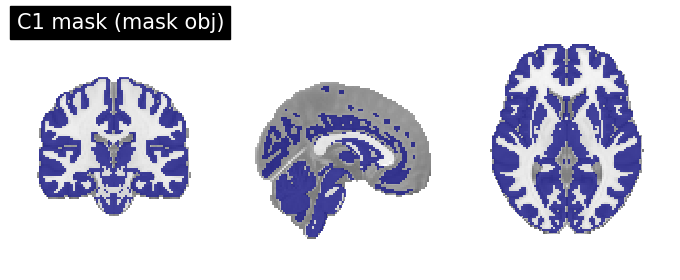

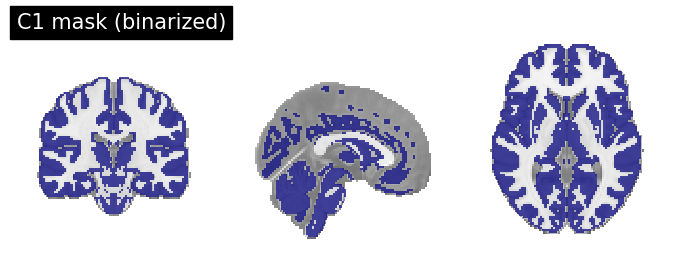

In [306]:
# Check information and visualize mask c1 

# Load raw data
C1_img_sub1 = nib.load(C1_paths[0])
C1_img_sub1_data = C1_img_sub1.get_fdata() 

# Check mask shape
C1_sub1_masker2 = nl.masking.compute_brain_mask(C1_img_sub1, mask_type="gm", opening=False) #mask_type="gm"
print("C1_img_sub1 shape: %s" % str(C1_img_sub1.shape))

# Compute mask, see type and shape
C1_sub1_masker = NiftiMasker(C1_sub1_masker2).fit() #mask_strategy="gm-template" C1_sub1_masker2
print("C1_sub1_masker type:" + str(type(C1_sub1_masker)))
print("C1_sub1_masker shape:" + str(C1_sub1_masker.mask_img_.shape))

# Compute binarized mask. 
C1_sub1_masker_data = image.load_img(C1_sub1_masker.mask_img_)
C1_sub1_masker_data_binarized = image.binarize_img(C1_sub1_masker_data)
print("C1_sub1_masker_data_binarized shape: " + str(C1_sub1_masker_data_binarized.shape))

# Plot the generated mask using the mask_img_ attribute
plot_roi(C1_paths[0], draw_cross=False, annotate=False, title="C1 mask (raw file)")
plot_roi(C1_sub1_masker.mask_img_, draw_cross=False, annotate=False, title="C1 mask (mask obj)")
plot_roi(C1_sub1_masker_data_binarized, draw_cross=False, annotate=False, title="C1 mask (binarized)")



In [279]:
# Load first participant raw COC for a single vol

sub1_coc = image.load_img(COC_PP_1_paths[0])
sub1_coc_single_vol = sub1_coc.slicer[..., 10]
print("sub1_coc_single_vol shape: " + str(sub1_coc_single_vol))


sub1_coc_single_vol shape: <class 'nibabel.nifti1.Nifti1Image'>
data shape (79, 95, 69)
affine: 
[[  -2.    0.    0.   78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -50.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 79 95 69  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'spm - 3D normalized - conv(6,6,6)- cleaned - 

In [281]:
# Resample binarized mask to COC vol shape 

C1_sub1_masker_data_binarized = image.resample_to_img(C1_sub1_masker_data_binarized, sub1_coc_single_vol, interpolation='nearest')

print("C1_sub1_masker_data_binarized shape: " + str(C1_sub1_masker_data_binarized.shape))

# Transform mask vol and raw data vol to np arrays.

C1_sub1_masker_data_binarized_data = image.get_data(C1_sub1_masker_data_binarized)

sub1_coc_single_vol_data = image.get_data(sub1_coc_single_vol)

print("sub1_coc_single_vol_data shape: " + str(sub1_coc_single_vol_data.shape))

# Extract the relevant voxels from the mask. 

sub1_coc_single_vol_data_binarized = sub1_coc_single_vol_data * C1_sub1_masker_data_binarized_data

print("sub1_coc_single_vol_data_binarized shape: " + str(sub1_coc_single_vol_data_binarized.shape))


C1_sub1_masker_data_binarized shape: (79, 95, 69)
sub1_coc_single_vol_data shape: (79, 95, 69)
sub1_coc_single_vol_data_binarized shape: (79, 95, 69)


sub1_coc_single_vol_data mean: 0.007916684
sub1_coc_single_vol_data_binarized mean: 0.007213623559044835


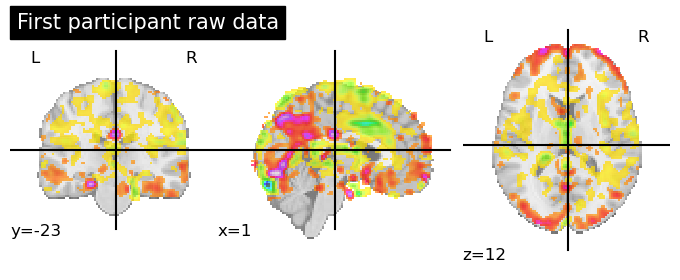

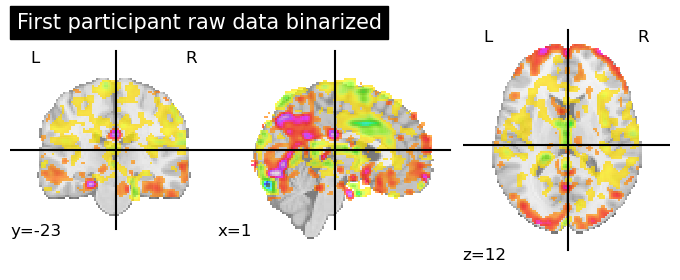

In [282]:
# Plot and check results. 
sub1_coc_single_vol_data_binarized_img = image.new_img_like(sub1_coc_single_vol, sub1_coc_single_vol_data)

plot_roi(sub1_coc_single_vol, title="First participant raw data")
plot_roi(sub1_coc_single_vol_data_binarized_img, title="First participant raw data binarized")

print("sub1_coc_single_vol_data mean: " + str(np.mean(sub1_coc_single_vol_data)))
print("sub1_coc_single_vol_data_binarized mean: " + str(np.mean(sub1_coc_single_vol_data_binarized)))



In [292]:
# Let's try to do it for all the volumes of a participant. 

# Get participants data. 
sub1_coc = image.load_img(COC_PP_1_paths[0])
sub1_coc_all_data = image.get_data(sub1_coc)

print("sub1_coc_all_data shape: " + str(sub1_coc_all_data.shape))

# Create zeros matrix to store.
shape_all=sub1_coc_all_data.shape
zeros_matrix_all_vols = np.zeros(shape_all)

for x in range(shape_all[3]):
    
    current_vol = sub1_coc_all_data[:, :, :, x]
    current_vol_binarized = current_vol * C1_sub1_masker_data_binarized_data
    zeros_matrix_all_vols[..., x] = current_vol_binarized


sub1_coc_all_data shape: (79, 95, 69, 233)


sub1_coc_all_vol_data mean: -0.0002600954
sub1_coc_all_vol_data_binarized mean: -0.00034788467951764356


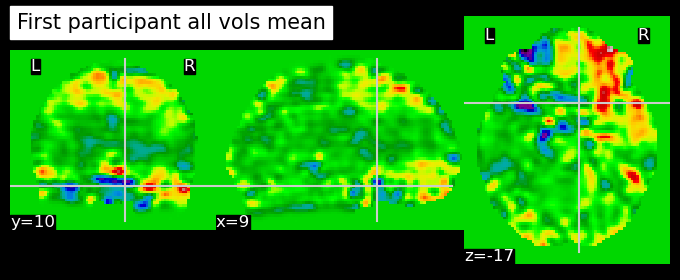

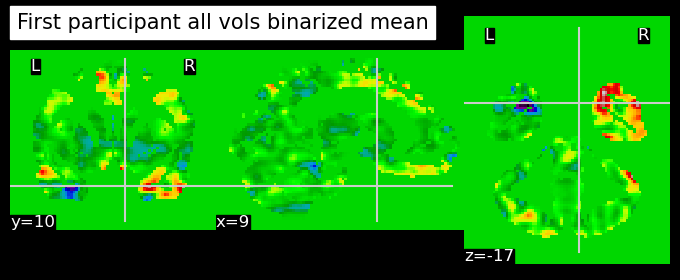

In [310]:
# Plot and check results. 
sub1_coc_all_vol_data_binarized_img = image.new_img_like(sub1_coc, zeros_matrix_all_vols)

sub1_coc_mean = image.mean_img(sub1_coc)
sub1_coc_all_vol_data_binarized_img_mean = image.mean_img(sub1_coc_all_vol_data_binarized_img)

plot_epi(sub1_coc_mean, title="First participant all vols mean", cut_coords=(9, 10, -17))
plot_epi(sub1_coc_all_vol_data_binarized_img_mean, title="First participant all vols binarized mean", cut_coords=(9, 10, -17))

print("sub1_coc_all_vol_data mean: " + str(np.mean(sub1_coc_all_data)))
print("sub1_coc_all_vol_data_binarized mean: " + str(np.mean(zeros_matrix_all_vols)))

In [313]:
# Same computation using the inverse transform method.
sub1_coc_all_vols_transformed = C1_sub1_masker.fit_transform(sub1_coc)
sub1_coc_all_vols_invtransformed = C1_sub1_masker.inverse_transform(sub1_coc_all_vols_transformed)

sub1_coc_all_vols_invtransformed_data = image.get_data(sub1_coc_all_vols_invtransformed)
sub1_coc_all_vols_invtransformed_mean_img = image.mean_img(sub1_coc_all_vols_invtransformed)

print("sub1_coc_all_vols_invtransformed mean: " + str(np.mean(sub1_coc_all_vols_invtransformed_data)))


sub1_coc_all_vols_invtransformed mean: 7.143112e-05


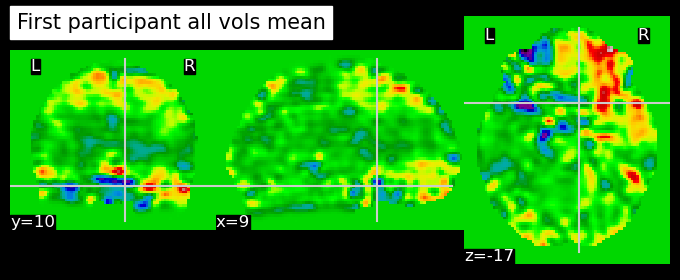

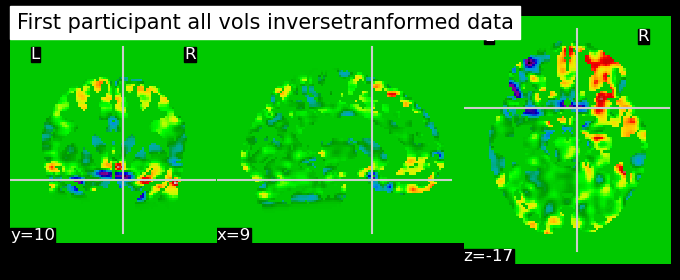

In [314]:
plot_epi(sub1_coc_mean, title="First participant all vols mean", cut_coords=(9, 10, -17))
plot_epi(sub1_coc_all_vols_invtransformed_mean_img, title="First participant all vols inversetranformed data", cut_coords=(9, 10, -17))

In [327]:
#sub1_coc_all_vols_invtransformed.to_filename("COCGM_files/to_filename_test.nii.gz")

Based on visual inspection it seems that using the "inverse trasnform" results in less loss of voxels compared to the matrix multiplication method. Hence, I will use the former. 

# Apply GM masks to all participants (COC & PLA)



In [332]:

save_dir_coc = "COCGM_files/"
save_dir_pla = "PLAGM_files/"

#apply_GM_Mask_2_RS(rs_data, gm_data, current_participant, condition, save_folder): 

for x in range(len(paritipants_list)): 

    print("Working on run " + str(x) + " " + str(paritipants_list[x]))
    print(C1_paths[x])
    print(COC_paths[x])
    print(PLA_paths[x])

    apply_GM_Mask_2_RS.remote(COC_paths[x], C1_paths[x], paritipants_list[x], "COC", save_dir_coc)
    apply_GM_Mask_2_RS.remote(PLA_paths[x], C1_paths[x], paritipants_list[x], "PLA", save_dir_pla)




Working on run 0 P5259
/Users/luisalvarez/Documents/Research_Elective_Data/CANCOC_PP_1/P5259/anat/wc1mpr_P5259_20120619.nii
CANCOC_PP_1/P5259/P5259COC/hcswaim_P5259_20120619_ts106_v001-238.nii
CANCOC_PP_1/P5259/P5259PLA/hcswaim_P5259_20120710_ts306_v001-238.nii
Working on run 1 P5232
/Users/luisalvarez/Documents/Research_Elective_Data/CANCOC_PP_1/P5232/anat/c1wmpr_P5232_20110811.nii
CANCOC_PP_1/P5232/P5232COC/hcswaim_P5232_20110811_ts206_v007-238.nii
CANCOC_PP_1/P5232/P5232PLA/hcswaim_P5232_20111135_ts306.nii
Working on run 2 P5235
/Users/luisalvarez/Documents/Research_Elective_Data/CANCOC_PP_1/P5235/anat/wc1mpr_P5235_20120623.nii
CANCOC_PP_1/P5235/P5235COC/hcswaim_P5235_20120611_ts106_v001-238.nii
CANCOC_PP_1/P5235/P5235PLA/hcswaim_P5235_20120623_ts306_v001-238.nii
Working on run 3 P5203
/Users/luisalvarez/Documents/Research_Elective_Data/CANCOC_PP_1/P5203/anat/c1wP5203_20100428_mpr_anatomy.nii
CANCOC_PP_1/P5203/P5203COC/hcswaim_P5203_20100507_ts306_GNG_v001-148.nii
CANCOC_PP_1/P5203/

(pid=39998) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
(pid=39998)   warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
(apply_GM_Mask_2_RS pid=39998) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:612: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
(apply_GM_Mask_2_RS pid=39998)   _resample_one_img(data[all_img + ind], A, b, target_shape,
(pid=40000) /Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see 